In [1]:
import matplotlib.pyplot as plt
import subprocess
from multiprocessing import cpu_count

In [2]:
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [3]:
HDFS_EXE = "/home/ubuntu/hadoop-3.3.6/bin/hdfs"
IP = "192.168.1.1"  # rember to set the real IP!
cores = cpu_count()

In [4]:
spark_session = SparkSession.builder\
        .master(f"spark://{IP}:7077")\
        .appName("ECAtemp")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", cores)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

sc = spark_session.sparkContext

sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/02 15:12:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data at a glance

All the data should have been extracted to HDFS: ```/data/tx/``` and ```/data/tn/``` for maximum and minimum temperatures, respectively. In addition, there is a station metadata file: ```/data/station_data.txt```.

Preview the contents of the directories:

In [5]:
for data_id in ("tx", "tn"):
    p = subprocess.run([HDFS_EXE, "dfs", "-ls", f"/data/{data_id}"],
                       check=True, capture_output=True)
    p = subprocess.run(["head", "-6"], input=p.stdout, capture_output=True)
    print(p.stdout.decode())

Found 2064 items
-rw-r--r--   1 ubuntu supergroup    1637898 2024-08-02 11:25 /data/tx/TX_STAID000002.txt
-rw-r--r--   1 ubuntu supergroup    1874571 2024-08-02 11:25 /data/tx/TX_STAID000004.txt
-rw-r--r--   1 ubuntu supergroup    1874582 2024-08-02 11:25 /data/tx/TX_STAID000005.txt
-rw-r--r--   1 ubuntu supergroup    1080231 2024-08-02 11:25 /data/tx/TX_STAID000007.txt
-rw-r--r--   1 ubuntu supergroup    1874586 2024-08-02 11:25 /data/tx/TX_STAID000008.txt

Found 2064 items
-rw-r--r--   1 ubuntu supergroup    1637896 2024-08-02 11:21 /data/tn/TN_STAID000002.txt
-rw-r--r--   1 ubuntu supergroup    1874571 2024-08-02 11:21 /data/tn/TN_STAID000004.txt
-rw-r--r--   1 ubuntu supergroup    1874582 2024-08-02 11:21 /data/tn/TN_STAID000005.txt
-rw-r--r--   1 ubuntu supergroup    1080231 2024-08-02 11:21 /data/tn/TN_STAID000007.txt
-rw-r--r--   1 ubuntu supergroup    1874586 2024-08-02 11:21 /data/tn/TN_STAID000008.txt



Get a preview of the first file in ```/data/tx/```:

In [6]:
p = subprocess.run([HDFS_EXE, "dfs", "-ls", "/data/tx"],
                   check=True, capture_output=True)
p = subprocess.run("head", input=p.stdout, capture_output=True)
sample_file = p.stdout.decode().split("\n")[1].strip().split()[-1]

p = subprocess.run([HDFS_EXE, "dfs", "-cat", sample_file],
                   check=True, capture_output=True)
p = subprocess.run(["head", "-30"], input=p.stdout, capture_output=True)
preview = p.stdout.decode()
print(preview)

EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on: 13-07-2024
THESE DATA CAN BE USED FOR NON-COMMERCIAL RESEARCH AND EDUCATION PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED: 

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE = -9999):

01-06 STAID: Station identifier
08-13 SOUID: Source identifier
15-22 DATE : Date YYYYMMDD
24-28 TX   : Maximum temperature in 0.1 &#176;C
30-34 Q_TX : quality code for TX (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station FALUN, SWEDEN (STAID: 2)
Blended and updated with sources:7 36438 
See files sources.txt and stations.txt for more info.

STAID, SOUID,    DATE,   TX, Q_TX
     2, 36438,19000101,   18,    0
     2, 36438,19000102,  -10,    0
     2, 36438,19000103,  -20,    0
     2, 36

Get a preview of the metadata file:

In [7]:
p = subprocess.run([HDFS_EXE, "dfs", "-cat", "/data/station_data.txt"],
                   check=True, capture_output=True)
p = subprocess.run("head", input=p.stdout, capture_output=True)
preview_meta = p.stdout.decode()
print(preview_meta)

STAID,STANAME,CN,LAT,LON,HGHT
2,FALUN,SE,60.616667,15.616667,160
4,LINKOEPING,SE,58.4,15.533056,93
5,LINKOEPING-MALMSLAETT,SE,58.4,15.533056,93
7,KARLSTAD-AIRPORT,SE,59.444444,13.3375,107
8,OESTERSUND,SE,63.183056,14.483056,376
9,OESTERSUND-FROESOEN,SE,63.183056,14.483056,376
10,STOCKHOLM,SE,59.35,18.05,44
11,KREMSMUENSTER (TAWES),AT,48.055,14.130833,382
12,GRAZ-UNIVERSITAET,AT,47.077778,15.448889,367



## Load & preprocess data

In [8]:
data_root = f"hdfs://{IP}:9000/data/"
rdds = {}
dfs  = {}

for data_id in ("tx", "tn"):
    data_dir = data_root + data_id
    rdds[data_id] = sc.textFile(data_dir)

We need to preprocess the max and min temperature data by exluding the first 20 lines from each file and converting the rest into a proper dataframe:

In [9]:
def Preprocess_step1(rdd):

    # read every file excluding first 20 lines
    df = rdd\
        .zipWithIndex()\
        .filter(lambda x: x[1] >= 20)\
        .map(lambda x: (x[0], ))\
        .toDF()

    # get column names from 1st row
    column_names = df.first()["_1"].split(",")
    column_names = [x.strip() for x in column_names]
    # drop 1st row
    df = df.withColumn("index", F.monotonically_increasing_id())
    df = df\
        .filter(df.index > 0)\
        .drop("index")

    # form columns
    for i,name in enumerate(column_names):
        df = df.withColumn(name, F.split(df["_1"], ",").getItem(i))
        df = df.withColumn(name, df[name].cast("int"))
    df = df.drop("_1")

    return df

In [10]:
for data_id in ("tx", "tn"):
    dfs[data_id] = Preprocess_step1(rdds[data_id])
    dfs[data_id].show(5)

+-----+-----+--------+---+----+
|STAID|SOUID|    DATE| TX|Q_TX|
+-----+-----+--------+---+----+
|    2|36438|19000101| 18|   0|
|    2|36438|19000102|-10|   0|
|    2|36438|19000103|-20|   0|
|    2|36438|19000104|-30|   0|
|    2|36438|19000105|-60|   0|
+-----+-----+--------+---+----+
only showing top 5 rows



+-----+-----+--------+----+----+
|STAID|SOUID|    DATE|  TN|Q_TN|
+-----+-----+--------+----+----+
|    2|36439|19000101| -30|   0|
|    2|36439|19000102| -50|   0|
|    2|36439|19000103| -70|   0|
|    2|36439|19000104|-110|   0|
|    2|36439|19000105|-190|   0|
+-----+-----+--------+----+----+
only showing top 5 rows



Then we need to:
1) filter out the suspect and missing values (represented by 1 and 9 in the last column);
2) convert the date from string to an appropriate type;
3) set a uniform date range for which data from all stations is available.

Note: in order to save disk space and time needed for copying files to HDFS, the input files were pre-filtered locally to satisfy the condition in (3).

In [11]:
def Preprocess_step2(df, data_id,
                     start_date = "1980-01-01",
                     end_date   = "2024-05-31"):
    temper_col = data_id.upper()
    df = df\
         .filter(df[f"Q_{temper_col}"]==0)\
         .withColumn("DATE", F.to_date(df["DATE"], format="yyyyMMdd"))
    df = df.filter((df["DATE"] >= start_date) & (df["DATE"] <= end_date))
    return df

In [12]:
for data_id in ("tx", "tn"):
    dfs[data_id] = Preprocess_step2(dfs[data_id], data_id)
    dfs[data_id].show(5)
    dfs[data_id].printSchema()

+-----+-----+----------+----+----+
|STAID|SOUID|      DATE|  TX|Q_TX|
+-----+-----+----------+----+----+
|    2|36438|1980-01-01| -13|   0|
|    2|36438|1980-01-02| -47|   0|
|    2|36438|1980-01-03| -94|   0|
|    2|36438|1980-01-04|-130|   0|
|    2|36438|1980-01-05| -30|   0|
+-----+-----+----------+----+----+
only showing top 5 rows

root
 |-- STAID: integer (nullable = true)
 |-- SOUID: integer (nullable = true)
 |-- DATE: date (nullable = true)
 |-- TX: integer (nullable = true)
 |-- Q_TX: integer (nullable = true)

+-----+-----+----------+----+----+
|STAID|SOUID|      DATE|  TN|Q_TN|
+-----+-----+----------+----+----+
|    2|36439|1980-01-01| -63|   0|
|    2|36439|1980-01-02|-142|   0|
|    2|36439|1980-01-03|-140|   0|
|    2|36439|1980-01-04|-247|   0|
|    2|36439|1980-01-05|-167|   0|
+-----+-----+----------+----+----+
only showing top 5 rows

root
 |-- STAID: integer (nullable = true)
 |-- SOUID: integer (nullable = true)
 |-- DATE: date (nullable = true)
 |-- TN: integer 

Lastly, we need to read the station metadata.

In [13]:
meta = spark_session.read.csv(data_root + "station_data.txt", header=True)
for col in ("LAT", "LON"):
    meta = meta.withColumn(col, meta[col].cast("float"))
meta = meta.withColumn("HGHT", meta["HGHT"].cast("int"))
meta.show(10)
meta.printSchema()

+-----+--------------------+---+---------+---------+----+
|STAID|             STANAME| CN|      LAT|      LON|HGHT|
+-----+--------------------+---+---------+---------+----+
|    2|               FALUN| SE| 60.61667|15.616667| 160|
|    4|          LINKOEPING| SE|     58.4|15.533056|  93|
|    5|LINKOEPING-MALMSL...| SE|     58.4|15.533056|  93|
|    7|    KARLSTAD-AIRPORT| SE|59.444443|  13.3375| 107|
|    8|          OESTERSUND| SE|63.183056|14.483056| 376|
|    9| OESTERSUND-FROESOEN| SE|63.183056|14.483056| 376|
|   10|           STOCKHOLM| SE|    59.35|    18.05|  44|
|   11|KREMSMUENSTER (TA...| AT|   48.055|14.130833| 382|
|   12|   GRAZ-UNIVERSITAET| AT|47.077778|15.448889| 367|
|   13|      INNSBRUCK-UNIV| AT|    47.26|11.384167| 578|
+-----+--------------------+---+---------+---------+----+
only showing top 10 rows

root
 |-- STAID: string (nullable = true)
 |-- STANAME: string (nullable = true)
 |-- CN: string (nullable = true)
 |-- LAT: float (nullable = true)
 |-- LON: flo

## Analysis

1) Split the stations by latitude into 10-degree brackets.

In [14]:
stats = {}
for func in (F.min, F.max):
    name  = func.__name__
    value = meta.agg(func("LAT")).collect()[0][0]
    stats[name] = value
    print(f"{name} latitude: {value}")

min latitude: 27.818889617919922
max latitude: 79.5


In [15]:
from math import floor, ceil

def DefBracket_10(latitude):
    """Returns the number of 10-degree latitude bracket:
    1 for latitude below 30 degrees, 2 for between 30 and 40, etc."""
    return max(floor(latitude)//10-1, 1)

def DefBracket_20(latitude):
    """Returns the number of 20-degree latitude bracket:
    1 for latitude below 30 degrees,
    2 for 30 to 50,
    3 for 50 to 70,
    4 for 70 to 80."""
    return max(1 + ceil((latitude-30)/20.0), 1)

def DefBracket_25(latitude):
    """Returns the number of 25-degree latitude bracket:
    1 for latitude below 30 degrees,
    2 for 30 to 55,
    3 for 55 to 80."""
    return max(1 + ceil((latitude-30)/25.0), 1)

DefBracketUDF = F.udf(lambda x: DefBracket_20(x), T.IntegerType())

In [16]:
meta = meta.withColumn("BRACKET", DefBracketUDF(meta.LAT))
meta.show(10)

+-----+--------------------+---+---------+---------+----+-------+
|STAID|             STANAME| CN|      LAT|      LON|HGHT|BRACKET|
+-----+--------------------+---+---------+---------+----+-------+
|    2|               FALUN| SE| 60.61667|15.616667| 160|      3|
|    4|          LINKOEPING| SE|     58.4|15.533056|  93|      3|
|    5|LINKOEPING-MALMSL...| SE|     58.4|15.533056|  93|      3|
|    7|    KARLSTAD-AIRPORT| SE|59.444443|  13.3375| 107|      3|
|    8|          OESTERSUND| SE|63.183056|14.483056| 376|      3|
|    9| OESTERSUND-FROESOEN| SE|63.183056|14.483056| 376|      3|
|   10|           STOCKHOLM| SE|    59.35|    18.05|  44|      3|
|   11|KREMSMUENSTER (TA...| AT|   48.055|14.130833| 382|      2|
|   12|   GRAZ-UNIVERSITAET| AT|47.077778|15.448889| 367|      2|
|   13|      INNSBRUCK-UNIV| AT|    47.26|11.384167| 578|      2|
+-----+--------------------+---+---------+---------+----+-------+
only showing top 10 rows



In [17]:
bracket_data = meta.drop("STANAME", "CN", "LAT", "LON", "HGHT")

for data_id in ("tx", "tn"):
    dfs[data_id] = dfs[data_id].join(bracket_data, on="STAID")
    dfs[data_id].show(5)

+-----+-----+----------+----+----+-------+
|STAID|SOUID|      DATE|  TX|Q_TX|BRACKET|
+-----+-----+----------+----+----+-------+
|    2|36438|1980-01-01| -13|   0|      3|
|    2|36438|1980-01-02| -47|   0|      3|
|    2|36438|1980-01-03| -94|   0|      3|
|    2|36438|1980-01-04|-130|   0|      3|
|    2|36438|1980-01-05| -30|   0|      3|
+-----+-----+----------+----+----+-------+
only showing top 5 rows

+-----+-----+----------+----+----+-------+
|STAID|SOUID|      DATE|  TN|Q_TN|BRACKET|
+-----+-----+----------+----+----+-------+
|    2|36439|1980-01-01| -63|   0|      3|
|    2|36439|1980-01-02|-142|   0|      3|
|    2|36439|1980-01-03|-140|   0|      3|
|    2|36439|1980-01-04|-247|   0|      3|
|    2|36439|1980-01-05|-167|   0|      3|
+-----+-----+----------+----+----+-------+
only showing top 5 rows



2. Aggregate temperature data by date and bracket, calculate average temperature for every day and latitude bracket.

In [18]:
result_avg = {}

for data_id in ("tx", "tn"):
    temper_col = data_id.upper()
    temper_col_avg = temper_col + "_AVG"

    result_avg[data_id] = dfs[data_id]\
        .drop("STAID", "SOUID", f"Q_{temper_col}")\
        .groupBy("DATE", "BRACKET")\
        .agg(F.avg(temper_col).alias(temper_col_avg))\
        .sort("BRACKET", "DATE")

    result_avg[data_id].show(5)

+----------+-------+-------+
|      DATE|BRACKET| TX_AVG|
+----------+-------+-------+
|1980-01-01|      1|185.375|
|1980-01-02|      1|  188.5|
|1980-01-03|      1| 184.25|
|1980-01-04|      1|184.875|
|1980-01-05|      1| 174.75|
+----------+-------+-------+
only showing top 5 rows



+----------+-------+-------+
|      DATE|BRACKET| TN_AVG|
+----------+-------+-------+
|1980-01-01|      1|133.125|
|1980-01-02|      1|137.625|
|1980-01-03|      1|  134.5|
|1980-01-04|      1|115.375|
|1980-01-05|      1|  114.5|
+----------+-------+-------+
only showing top 5 rows



3. Calculate the yearly temperature trends across all brackets. Year 2024 is still ongoing, so it will be excluded.

In [19]:
result_trend = {}

for data_id in ("tx", "tn"):
    temper_col = data_id.upper()
    temper_col_avg    = temper_col + "_AVG"
    temper_col_trend  = temper_col + "_TREND"

    result_trend[data_id] = result_avg[data_id]\
        .filter(result_avg[data_id]["DATE"] < "2024-01-01")\
        .withColumn("YEAR", F.trunc("DATE", "year"))\
        .groupBy("YEAR")\
        .agg(F.avg(temper_col_avg).alias(temper_col_trend))\
        .sort("YEAR")

    result_trend[data_id].show(5)

+----------+------------------+
|      YEAR|          TX_TREND|
+----------+------------------+
|1980-01-01|110.36454123534106|
|1981-01-01|111.95274806562058|
|1982-01-01|116.07384997759513|
|1983-01-01|120.02505478115862|
|1984-01-01|117.72603420101294|
+----------+------------------+
only showing top 5 rows



+----------+------------------+
|      YEAR|          TN_TREND|
+----------+------------------+
|1980-01-01| 39.89561315316904|
|1981-01-01|40.797967990862595|
|1982-01-01| 45.96489017179212|
|1983-01-01| 48.38396831165588|
|1984-01-01|49.497353924233934|
+----------+------------------+
only showing top 5 rows



## Saving & Plotting

In [20]:
result_avg_pandas   = {}
result_trend_pandas = {}
for data_id in ("tx", "tn"):
    result_avg_pandas[data_id]   = result_avg[data_id].toPandas()
    result_trend_pandas[data_id] = result_trend[data_id].toPandas()

In [21]:
for data_id in ("tx", "tn"):
    result_avg_pandas[data_id].to_csv(f"result_{data_id}_avg.csv", index=False)
    result_trend_pandas[data_id].to_csv(f"result_{data_id}_trend.csv", index=False)

The temperature data is stored in 0.1 &#176;C, so it needs to be scaled by 0.1 when plotting.

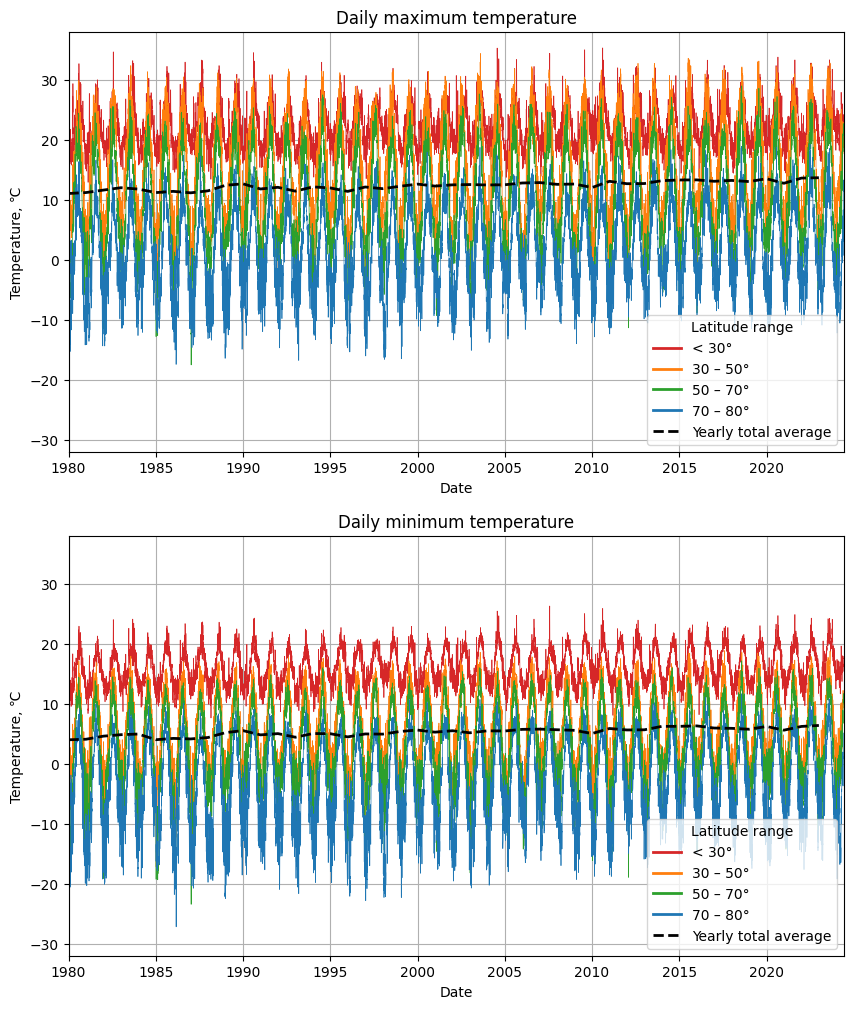

In [22]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 12))

title_label = {"tx": "maximum", "tn": "minimum"}
line_label  = {1: u"< 30\u00B0",
               2: u"30 \u2013 50\u00B0",
               3: u"50 \u2013 70\u00B0",
               4: u"70 \u2013 80\u00B0"}
line_color  = {1: "#d62728",
               2: "#ff7f0e",
               3: "#2ca02c",
               4: "#1f77b4"}

for i, data_id in enumerate(("tx", "tn")):
    temper_col = data_id.upper()
    temper_col_avg   = temper_col + "_AVG"
    temper_col_trend = temper_col + "_TREND"
    
    for b in range(1,5):
        data = result_avg_pandas[data_id][result_avg_pandas[data_id]["BRACKET"]==b]
        ax[i].plot(data["DATE"], data[temper_col_avg]*0.1,
                   linewidth=0.5, color=line_color[b],
                   label=line_label[b])

    data_trend = result_trend_pandas[data_id]
    ax[i].plot(data_trend["YEAR"], data_trend[temper_col_trend]*0.1,
               linewidth=2.0, color="black", linestyle="dashed",
               label="Yearly total average")

    ax[i].grid()
    ax[i].set_xlim(min(data["DATE"]), max(data["DATE"]))
    ax[i].set_ylim(-32, 38)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel(u"Temperature, \u2103")
    ax[i].set_title(f"Daily {title_label[data_id]} temperature")

    leg = ax[i].legend(title="Latitude range")
    for line in leg.get_lines():
        line.set_linewidth(2.0)

ax[0].tick_params(axis="x", bottom=True, labelbottom=True)

plt.savefig("result.png", dpi=300, bbox_inches="tight")
plt.show()

## Wrapping up

In [23]:
spark_session.stop()